# Helper Functions

In [23]:
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import numpy as np

def roc_curve(ground_truth, predictions, steps=200):
    inds = np.isnan(predictions)
    predictions = predictions[~inds]
    ground_truth = ground_truth[~inds]
    ground_truth = ground_truth!=0
    positives = np.sum(ground_truth)
    negatives = np.sum(np.logical_not(ground_truth))
    threshs = np.linspace(np.min(predictions),np.max(predictions),steps)
    tpr = [np.sum(np.logical_and(ground_truth,predictions >= thresh))/positives for thresh in threshs]
    fpr = [np.sum(np.logical_and(np.logical_not(ground_truth),predictions >= thresh))/negatives for thresh in threshs]
    return fpr, tpr

def prec_recall_curve(ground_truth, predictions, steps=200):
    inds = np.isnan(predictions)
    predictions = predictions[~inds]
    ground_truth = ground_truth[~inds]
    ground_truth = ground_truth!=0
    positives = np.sum(ground_truth)
    negatives = np.sum(np.logical_not(ground_truth))
    threshs = np.linspace(np.min(predictions),np.max(predictions),steps)
    precision = [np.sum(np.logical_and(ground_truth,predictions >= thresh))/(np.sum(np.logical_and(ground_truth,predictions >= thresh)) + np.sum(np.logical_and(np.logical_not(ground_truth),predictions >= thresh))) for thresh in threshs]
    recall = [np.sum(np.logical_and(ground_truth,predictions >= thresh))/positives for thresh in threshs]
    noskill = positives / (positives+negatives)
    return precision, recall, noskill

In [2]:
from sklearn.preprocessing import MinMaxScaler

def minmax_normalize(data):
    scaler = MinMaxScaler()
    return scaler.fit_transform(data), scaler

def minmax_inverse_normalize(data, scaler):
    return scaler.inverse_transform(data)

In [3]:
from sklearn.preprocessing import StandardScaler

def standard_normalize(data):
    scaler = StandardScaler()
    return scaler.fit_transform(data), scaler

def standard_inverse_normalize(data, scaler):
    return scaler.inverse_transform(data)

# Load Data

In [4]:
# create directory for the results
import os
results_path = os.path.join("..", "..", "results")
! mkdir $results_path

mkdir: ../../results: File exists


In [5]:
data_path = os.path.join("..", "..", "data")

In [7]:
import pickle
import numpy as np

file = "split_transfer_synthetic_data.p"
data = pickle.load(open(os.path.join(data_path, file), "rb"))

for key, array in data.items():
    print(key, ":", np.array(array).shape)

X_known : (100, 30)
W_known : (100, 5)
H_known : (5, 30)
indicator : (30,)
X_target_1 : (100, 40)
W_target_1 : (100, 6)
H_target_1 : (6, 40)
y_true_1 : (40,)
X_target_2 : (100, 35)
W_target_2 : (100, 6)
H_target_2 : (6, 35)
y_true_2 : (35,)


In [12]:
# known set
X_known = data["X_known"]
W_known = data["W_known"]
H_known = data["H_known"]
indicator = np.array(data["indicator"])

# target set 1
X_target_1 = data["X_target_1"]
W_target_1 = data["W_target_1"]
H_target_1 = data["H_target_1"]
y_true_1 = np.array(data["y_true_1"])

# target set 2
X_target_2 = data["X_target_2"]
W_target_2 = data["W_target_2"]
H_target_2 = data["H_target_2"]
y_true_2 = np.array(data["y_true_2"])

# Normalize Train and Test Data Here

**Example how to use Min Max scaler:**
```python
X_known_nrm, known_scaler = minmax_normalize(X_known)
X_target_1_nrm, target_1_scaler = minmax_normalize(X_target_1)
X_target_2_nrm, target_2_scaler = minmax_normalize(X_target_2)
```

**Scaled data can be reversed like below:**
```pyhthon
X_known = minmax_inverse_normalize(X_known_nrm, known_scaler)
```

**Similarly, Standard scaler can be used via the below functions:**
- ```X_known_nrm, known_scaler = standard_normalize(X_known)```
- ```X_known = standard_inverse_normalize(X_known_nrm, known_scaler)```

# Settings

In [13]:
nmfk_params_known = {
    "n_perturbs":30,
    "n_iters":1000,
    "epsilon":0.015,
    "n_jobs":-1,
    "init":"nnsvd",
    "use_gpu":False,
    "save_path":results_path,
    "save_output":True,
    "sill_thresh":0.5,
    'nmf_method':'nmf_fro_mu',
}

nmfk_params_target = {
    "n_perturbs":30,
    "n_iters":1000,
    "epsilon":0.01,
    "n_jobs":-1,
    "init":"nnsvd",
    "use_gpu":False,
    "save_path":results_path,
    "save_output":True,
    "sill_thresh":0.8,
    'nmf_method':'nmf_fro_mu',
}

nmfk_params_split = {
    "n_perturbs":30,
    "n_iters":1000,
    "epsilon":0.015,
    "n_jobs":-1,
    "init":"nnsvd",
    "use_gpu":False,
    "save_path":results_path,
    "save_output":True,
    "sill_thresh":0.6,
    'nmf_method':'nmf_fro_mu',
}

In [14]:
# parameters of the transfer method
transfer_params = {
}

In [15]:
SPLIT_transfer_params = {
    # K range to search for known set
    "Ks_known":range(1,10,1),
    # K range to search for target set
    "Ks_target":range(1,10,1),
    # K search step-size when doing split
    "Ks_split_step":1,
    # K search minimum K to look at when doing split
    "Ks_split_min":1,
    # Uses GPU if True when doing regression
    "H_regress_gpu":False,
    # What method to use when constructing the H Learned (can be "regress" or "MitH")
    "H_learn_method":"regress",
    # How to initilize H Learned when doing regression (can be "random" or "MitH")
    "H_regress_init":"MitH",
    # NMFk parameters for known, target, and split 
    "nmfk_params_known":nmfk_params_known,
    "nmfk_params_target":nmfk_params_target,
    "nmfk_params_split":nmfk_params_split,
    # How many H update iterations if doing regression
    "H_regress_iters":1000,
    # If doing regression for H Learned, which update to use (can be "fro", or "kl")
    "H_regress_method":"fro",
    # Parameters for the transfer, i.e. the SVR 
    "transfer_regress_params":transfer_params,
    # what transfer learning to use, currently on SVR (can me model)
    "transfer_method":"SVR",
    # if True, prints progress of SPLIT transfer
    "verbose":True,
    # random seed
    "random_state":42,
    # if transfer_method="model", pass the transfer model
    # example: 
    # from sklearn.linear_model import SGDRegressor
    # "transfer_method": "model",
    # "transfer_model":SGDRegressor
    "transfer_model":None
}

# Split Transfer Classifier Method (Target 1)

In [16]:
from TELF.factorization import SPLITTransfer

model = SPLITTransfer(**SPLIT_transfer_params)

n_perturbs: 30
perturb_type: uniform
n_iters: 1000
epsilon: 0.015
init: nnsvd
save_path: ../../results
save_output: True
use_gpu: False
verbose: True
nmf_verbose: False
perturb_verbose: False
transpose: False
collect_output: True
sill_thresh: 0.5
predict_k: True
predict_k_method: WH_sill
n_jobs: 12
n_nodes: 1
nmf: <function nmf at 0x1689709a0>
nmf_method: nmf_fro_mu
nmf_obj_params: {}
clustering_obj_params: {}
pruned: True
calculate_error: True
consensus_mat: False
use_consensus_stopping: 0
mask: None
calculate_pac: False
simple_plot: True
get_plot_data: False
perturb_multiprocessing: False
k_search_method: linear
H_sill_thresh: None
factor_thresholding: None
factor_thresholding_H_regression: None
factor_thresholding_obj_params: {}
factor_thresholding_H_regression_obj_params: {}
clustering_method: kmeans
device: [-1]
lock: <unlocked _thread.lock object at 0x14f95ec40>
K_search_settings: {'lock': <unlocked _thread.lock object at 0x16891c6c0>, 'k_search_method': 'linear', 'sill_thresh': 

/Users/maksim/Desktop/Code/telf_internal/TELF/factorization/NMFk.py:855: UserWarning: calculate_error is True! Error calculation can make the runtime longer and take up more memory space!
  warnings.warn(


## Other Example Use Cases
**Below are the other ways to use the tool, it is similar to Scikit-learn.**

- **Option 1:**
```python
y_pred = model.fit(X_known, X_target).transform(indicator).predict(test=True)
```


- **Option 2:**
```python
model.fit(X_known, X_target)
model.transform(indicator)
# if test=False, it predicts on the training set.
y_pred = model.predict(test=True)
```


- **Option 3:**
```python
model.fit_transform(X_known, X_target, indicator)
y_pred = model.predict(test=True)
```

**There are also individual fit methods available:**
```python
model.fit_known(X_known)
model.fit_target(X_target)
model.fit_split()
model.learn_H()
model.fit_transfer(indicator)
y_pred = model.predict(test=True)
```

**The data in the object can be accessed directly:**
```python
print(model.known.keys())
print(model.target.keys())
print(model.split.keys())

# example accessing the W of known set
print(model.know["W"].shape)
```

**Known and Target set W and H can be manually set to fit the SPLIT part only:**
```python
# set Xs for known and target, which is needed for regression
model.known["X"] = X_known
model.target["X"] = X_target_1

# set the Ks for known and target
model.known["k"] = W_known.shape[1]
model.target["k"] = W_target_1.shape[1]

# set W and H for known
model.known["W"] = W_known
model.known["H"] = H_known

# set W and H for target
model.target["W"] = W_target_1
model.target["H"] = H_target_1

# fit SPLIT only
model.fit_split()
model.transform(indicator)
model.predict(test=True)
```

Fit the model, i.e. run the NMFk for known, target, and split:

In [17]:
model.fit(X_known, X_target_1)

/Users/maksim/Desktop/Code/telf_internal/TELF/factorization/NMFk.py:1078: UserWarning: X is data type float64. Whic is not float32. Higher precision will result in significantly longer runtime!
  warnings.warn(


n_perturbs: 30
perturb_type: uniform
n_iters: 1000
epsilon: 0.015
init: nnsvd
save_path: ../../results
save_output: True
use_gpu: False
verbose: True
nmf_verbose: False
perturb_verbose: False
transpose: False
collect_output: True
sill_thresh: 0.5
predict_k: True
predict_k_method: WH_sill
n_jobs: 12
n_nodes: 1
nmf: <function nmf at 0x1689709a0>
nmf_method: nmf_fro_mu
nmf_obj_params: {}
clustering_obj_params: {}
pruned: True
calculate_error: True
consensus_mat: False
use_consensus_stopping: 0
mask: None
calculate_pac: False
simple_plot: True
get_plot_data: False
perturb_multiprocessing: False
k_search_method: linear
H_sill_thresh: None
factor_thresholding: None
factor_thresholding_H_regression: None
factor_thresholding_obj_params: {}
factor_thresholding_H_regression_obj_params: {}
clustering_method: kmeans
device: [-1]
lock: <unlocked _thread.lock object at 0x168f7af40>
K_search_settings: {'lock': <unlocked _thread.lock object at 0x168f7a6c0>, 'k_search_method': 'linear', 'sill_thresh': 

  0%|          | 0/9 [00:00<?, ?it/s]

/Users/maksim/miniconda3/envs/TELF/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/maksim/miniconda3/envs/TELF/lib/python3.11/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 9/9 [00:09<00:00,  1.05s/it]


n_perturbs: 30
perturb_type: uniform
n_iters: 1000
epsilon: 0.01
init: nnsvd
save_path: ../../results
save_output: True
use_gpu: False
verbose: True
nmf_verbose: False
perturb_verbose: False
transpose: False
collect_output: True
sill_thresh: 0.8
predict_k: True
predict_k_method: WH_sill
n_jobs: 12
n_nodes: 1
nmf: <function nmf at 0x1689709a0>
nmf_method: nmf_fro_mu
nmf_obj_params: {}
clustering_obj_params: {}
pruned: True
calculate_error: True
consensus_mat: False
use_consensus_stopping: 0
mask: None
calculate_pac: False
simple_plot: True
get_plot_data: False
perturb_multiprocessing: False
k_search_method: linear
H_sill_thresh: None
factor_thresholding: None
factor_thresholding_H_regression: None
factor_thresholding_obj_params: {}
factor_thresholding_H_regression_obj_params: {}
clustering_method: kmeans
device: [-1]
lock: <unlocked _thread.lock object at 0x168e786c0>
K_search_settings: {'lock': <unlocked _thread.lock object at 0x168374100>, 'k_search_method': 'linear', 'sill_thresh': 0

100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


n_perturbs: 30
perturb_type: uniform
n_iters: 1000
epsilon: 0.015
init: nnsvd
save_path: ../../results
save_output: True
use_gpu: False
verbose: True
nmf_verbose: False
perturb_verbose: False
transpose: False
collect_output: True
sill_thresh: 0.6
predict_k: True
predict_k_method: WH_sill
n_jobs: 12
n_nodes: 1
nmf: <function nmf at 0x1689709a0>
nmf_method: nmf_fro_mu
nmf_obj_params: {}
clustering_obj_params: {}
pruned: True
calculate_error: True
consensus_mat: False
use_consensus_stopping: 0
mask: None
calculate_pac: False
simple_plot: True
get_plot_data: False
perturb_multiprocessing: False
k_search_method: linear
H_sill_thresh: None
factor_thresholding: None
factor_thresholding_H_regression: None
factor_thresholding_obj_params: {}
factor_thresholding_H_regression_obj_params: {}
clustering_method: kmeans
device: [-1]
lock: <unlocked _thread.lock object at 0x169496d80>
K_search_settings: {'lock': <unlocked _thread.lock object at 0x14f9ef740>, 'k_search_method': 'linear', 'sill_thresh': 

100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Do the transfer learning:

In [18]:
model.transform(indicator)

Applying regression to get known H learned...
Applying regression to get target H learned...
Applying transfer learning...


## Results (Target 1)

#### Do prediction

In [19]:
y_pred_train = model.predict(test=False)
y_pred_test = model.predict(test=True)

#### ROC Curve

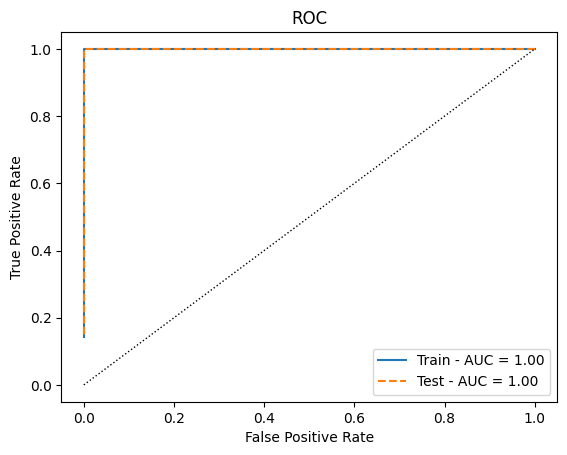

In [25]:
plt.figure(dpi=100)

fpr, tpr = roc_curve(indicator, y_pred_train)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label = 'Train - AUC = %0.2f' % roc_auc)

fpr, tpr = roc_curve(y_true_1, y_pred_test)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label = 'Test - AUC = %0.2f' % roc_auc, linestyle="--")

plt.title('ROC')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], 'black', linestyle=':', lw=1)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### PR Curve

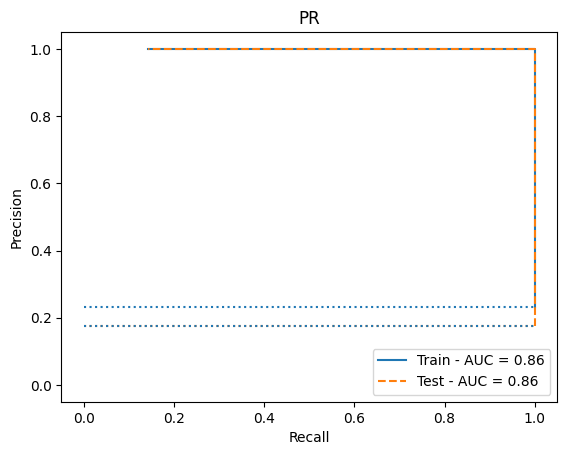

In [26]:
plt.figure(dpi=100)

prec, recall, noskill = prec_recall_curve(indicator, y_pred_train)
roc_auc = metrics.auc(recall, prec)
plt.plot(recall, prec, label = 'Train - AUC = %0.2f' % roc_auc)
plt.plot([0,1],[noskill,noskill],color='C0',linestyle=':')

prec, recall, noskill = prec_recall_curve(y_true_1, y_pred_test)
roc_auc = metrics.auc(recall, prec)
plt.plot(recall, prec, label = 'Test - AUC = %0.2f' % roc_auc, linestyle="--")
plt.plot([0,1],[noskill,noskill],color='C1',linestyle=':')

plt.title('PR')
plt.legend(loc = 'lower right')
plt.plot([0,1],[noskill,noskill],color='C0',linestyle=':')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

#### Look at the Predictions and Labels

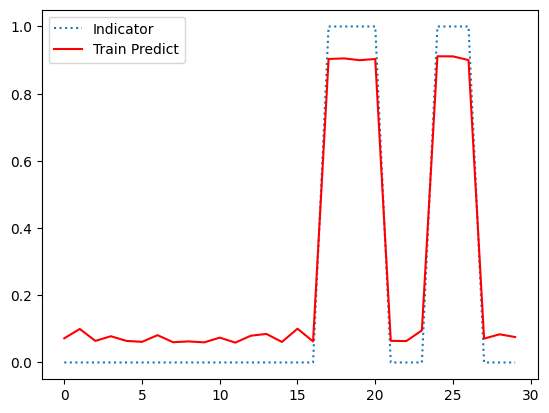

In [27]:
plt.figure(dpi=100)

plt.plot(indicator, label="Indicator", linestyle=":")
plt.plot(np.arange(0, len(y_pred_train), 1), y_pred_train, 
         label="Train Predict", color="red")

plt.legend()
plt.show()

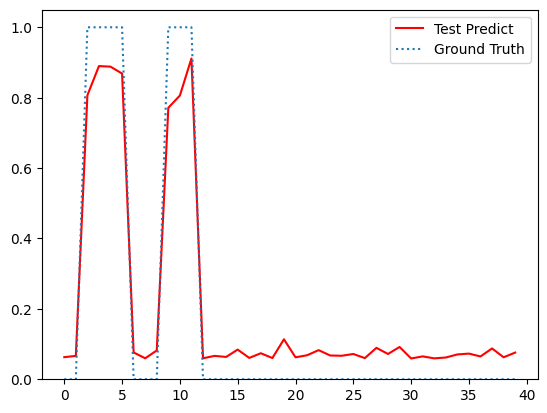

In [28]:
plt.figure(dpi=100)
plt.ylim([0, 1.05])
plt.plot(np.arange(0, len(y_pred_test), 1),y_pred_test, 
         label="Test Predict", color="red")
plt.plot(y_true_1, label="Ground Truth", linestyle=":")
plt.legend()
plt.show()

### Feature Correlation

In [29]:
import pandas as pd

df = pd.DataFrame(model.known["H_learned"].T)
df["y"] = indicator

In [30]:
corr_matrix = df.corr()
corr_matrix["y"].sort_values(ascending=False)

y    1.000000
0    0.986588
1    0.961703
Name: y, dtype: float64

### Investigate Features with Shap
- Install shap with: ```pip install shap```

In [21]:
import shap

explainer = shap.KernelExplainer(
    model.transfer_model.predict,
    model.known["H_learned"].T
)

/Users/maksimekineren/Desktop/Maksim/LANL/Code/nmfk-master/.eggs/tqdm-4.63.0-py3.8.egg/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
shap.initjs()

In [23]:
shap_values = explainer.shap_values(model.known["H_learned"].T)

100%|███████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.73it/s]


In [24]:
shap.plots.force(explainer.expected_value, shap_values)

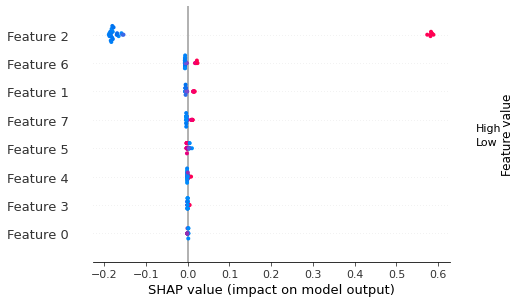

In [25]:
shap.summary_plot(shap_values, model.known["H_learned"].T)

### Look at Feature Importances

**First fit the transfer model on the original H:**

In [31]:
model.known["H_learned"] = H_known
model.fit_transfer(indicator)

Applying transfer learning...


Feature 3
Importance Mean= 0.3360
Importance STD=  +/- 0.0712
--------------------------------
Feature 5
Importance Mean= 0.3340
Importance STD=  +/- 0.0704
--------------------------------
Feature 1
Importance Mean= 0.3176
Importance STD=  +/- 0.0677
--------------------------------


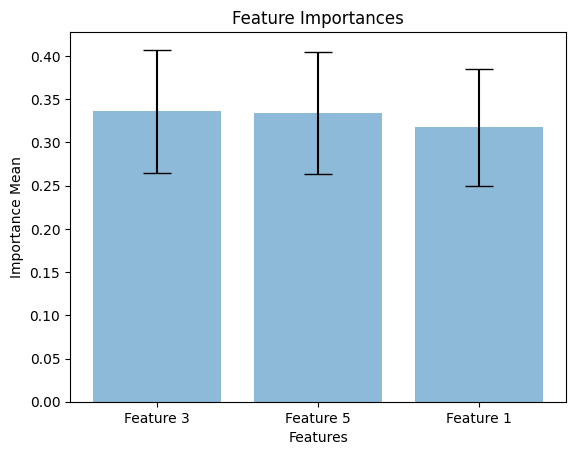

In [32]:
# parameters for the Permutation feature importance
permi_params = {
    "n_repeats":30,
    "random_state":42
}

feature_importances = model.get_feature_importances(
    indicator, 
    permi_params,
    feature_names=[],
    plot=True
)

In [33]:
feature_importances

{'Feature 3': {'importance_mean': np.float64(0.336),
  'importance_std': np.float64(0.0712)},
 'Feature 5': {'importance_mean': np.float64(0.334),
  'importance_std': np.float64(0.0704)},
 'Feature 1': {'importance_mean': np.float64(0.3176),
  'importance_std': np.float64(0.0677)},
 'indices': [np.int64(2), np.int64(4), np.int64(0)]}

# Split Transfer Classifier Method (Target 2)

In [34]:
from TELF.factorization import SPLITTransfer

model = SPLITTransfer(**SPLIT_transfer_params)

n_perturbs: 30
perturb_type: uniform
n_iters: 1000
epsilon: 0.015
init: nnsvd
save_path: ../../results
save_output: True
use_gpu: False
verbose: True
nmf_verbose: False
perturb_verbose: False
transpose: False
collect_output: True
sill_thresh: 0.5
predict_k: True
predict_k_method: WH_sill
n_jobs: 12
n_nodes: 1
nmf: <function nmf at 0x1689709a0>
nmf_method: nmf_fro_mu
nmf_obj_params: {}
clustering_obj_params: {}
pruned: True
calculate_error: True
consensus_mat: False
use_consensus_stopping: 0
mask: None
calculate_pac: False
simple_plot: True
get_plot_data: False
perturb_multiprocessing: False
k_search_method: linear
H_sill_thresh: None
factor_thresholding: None
factor_thresholding_H_regression: None
factor_thresholding_obj_params: {}
factor_thresholding_H_regression_obj_params: {}
clustering_method: kmeans
device: [-1]
lock: <unlocked _thread.lock object at 0x16a040b80>
K_search_settings: {'lock': <unlocked _thread.lock object at 0x1696a4900>, 'k_search_method': 'linear', 'sill_thresh': 

/Users/maksim/Desktop/Code/telf_internal/TELF/factorization/NMFk.py:855: UserWarning: calculate_error is True! Error calculation can make the runtime longer and take up more memory space!
  warnings.warn(


In [35]:
model.fit_transform(X_known, X_target_2, indicator)

/Users/maksim/Desktop/Code/telf_internal/TELF/factorization/NMFk.py:1078: UserWarning: X is data type float64. Whic is not float32. Higher precision will result in significantly longer runtime!
  warnings.warn(


n_perturbs: 30
perturb_type: uniform
n_iters: 1000
epsilon: 0.015
init: nnsvd
save_path: ../../results
save_output: True
use_gpu: False
verbose: True
nmf_verbose: False
perturb_verbose: False
transpose: False
collect_output: True
sill_thresh: 0.5
predict_k: True
predict_k_method: WH_sill
n_jobs: 12
n_nodes: 1
nmf: <function nmf at 0x1689709a0>
nmf_method: nmf_fro_mu
nmf_obj_params: {}
clustering_obj_params: {}
pruned: True
calculate_error: True
consensus_mat: False
use_consensus_stopping: 0
mask: None
calculate_pac: False
simple_plot: True
get_plot_data: False
perturb_multiprocessing: False
k_search_method: linear
H_sill_thresh: None
factor_thresholding: None
factor_thresholding_H_regression: None
factor_thresholding_obj_params: {}
factor_thresholding_H_regression_obj_params: {}
clustering_method: kmeans
device: [-1]
lock: <unlocked _thread.lock object at 0x16a0107c0>
K_search_settings: {'lock': <unlocked _thread.lock object at 0x169789d00>, 'k_search_method': 'linear', 'sill_thresh': 

  0%|          | 0/9 [00:00<?, ?it/s]/Users/maksim/miniconda3/envs/TELF/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/maksim/miniconda3/envs/TELF/lib/python3.11/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 9/9 [00:09<00:00,  1.05s/it]


n_perturbs: 30
perturb_type: uniform
n_iters: 1000
epsilon: 0.01
init: nnsvd
save_path: ../../results
save_output: True
use_gpu: False
verbose: True
nmf_verbose: False
perturb_verbose: False
transpose: False
collect_output: True
sill_thresh: 0.8
predict_k: True
predict_k_method: WH_sill
n_jobs: 12
n_nodes: 1
nmf: <function nmf at 0x1689709a0>
nmf_method: nmf_fro_mu
nmf_obj_params: {}
clustering_obj_params: {}
pruned: True
calculate_error: True
consensus_mat: False
use_consensus_stopping: 0
mask: None
calculate_pac: False
simple_plot: True
get_plot_data: False
perturb_multiprocessing: False
k_search_method: linear
H_sill_thresh: None
factor_thresholding: None
factor_thresholding_H_regression: None
factor_thresholding_obj_params: {}
factor_thresholding_H_regression_obj_params: {}
clustering_method: kmeans
device: [-1]
lock: <unlocked _thread.lock object at 0x16975b1c0>
K_search_settings: {'lock': <unlocked _thread.lock object at 0x16a0dc900>, 'k_search_method': 'linear', 'sill_thresh': 0

100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


n_perturbs: 30
perturb_type: uniform
n_iters: 1000
epsilon: 0.015
init: nnsvd
save_path: ../../results
save_output: True
use_gpu: False
verbose: True
nmf_verbose: False
perturb_verbose: False
transpose: False
collect_output: True
sill_thresh: 0.6
predict_k: True
predict_k_method: WH_sill
n_jobs: 12
n_nodes: 1
nmf: <function nmf at 0x1689709a0>
nmf_method: nmf_fro_mu
nmf_obj_params: {}
clustering_obj_params: {}
pruned: True
calculate_error: True
consensus_mat: False
use_consensus_stopping: 0
mask: None
calculate_pac: False
simple_plot: True
get_plot_data: False
perturb_multiprocessing: False
k_search_method: linear
H_sill_thresh: None
factor_thresholding: None
factor_thresholding_H_regression: None
factor_thresholding_obj_params: {}
factor_thresholding_H_regression_obj_params: {}
clustering_method: kmeans
device: [-1]
lock: <unlocked _thread.lock object at 0x169474600>
K_search_settings: {'lock': <unlocked _thread.lock object at 0x16975bd00>, 'k_search_method': 'linear', 'sill_thresh': 

100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Applying regression to get known H learned...
Applying regression to get target H learned...
Applying transfer learning...


## Results (Target 1)

#### Do prediction

In [36]:
y_pred_train = model.predict(test=False)
y_pred_test = model.predict(test=True)

#### ROC Curve

/var/folders/lr/5nshhpy542x47gz560f07r340011f_/T/ipykernel_39827/1448630045.py:12: RuntimeWarning: invalid value encountered in scalar divide
  tpr = [np.sum(np.logical_and(ground_truth,predictions >= thresh))/positives for thresh in threshs]


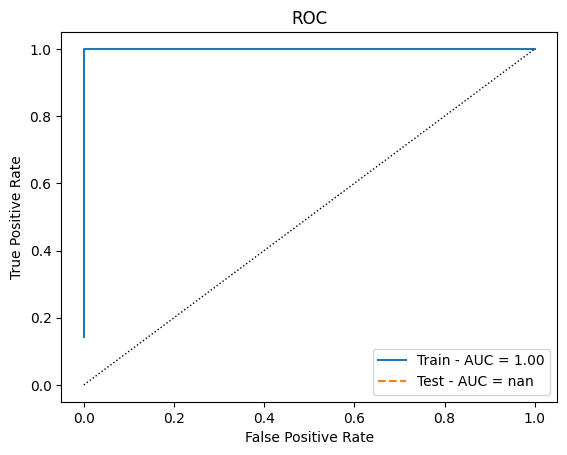

In [37]:
plt.figure(dpi=100)

fpr, tpr = roc_curve(indicator, y_pred_train)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label = 'Train - AUC = %0.2f' % roc_auc)

fpr, tpr = roc_curve(y_true_2, y_pred_test)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label = 'Test - AUC = %0.2f' % roc_auc, linestyle="--")

plt.title('ROC')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], 'black', linestyle=':', lw=1)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### PR Curve

/var/folders/lr/5nshhpy542x47gz560f07r340011f_/T/ipykernel_39827/1448630045.py:25: RuntimeWarning: invalid value encountered in scalar divide
  recall = [np.sum(np.logical_and(ground_truth,predictions >= thresh))/positives for thresh in threshs]


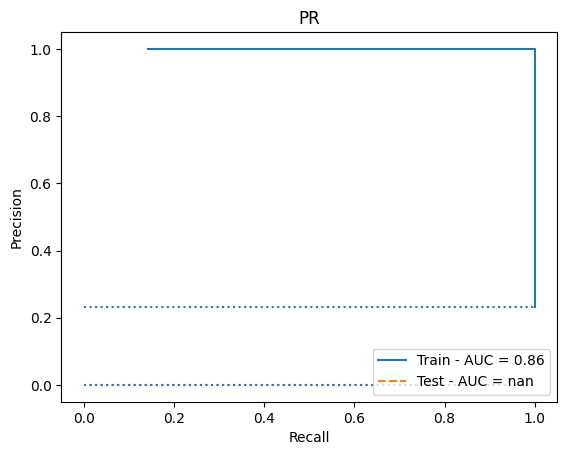

In [39]:
plt.figure(dpi=100)

prec, recall, noskill = prec_recall_curve(indicator, y_pred_train)
roc_auc = metrics.auc(recall, prec)
plt.plot(recall, prec, label = 'Train - AUC = %0.2f' % roc_auc)
plt.plot([0,1],[noskill,noskill],color='C0',linestyle=':')

prec, recall, noskill = prec_recall_curve(y_true_2, y_pred_test)
roc_auc = metrics.auc(recall, prec)
plt.plot(recall, prec, label = 'Test - AUC = %0.2f' % roc_auc, linestyle="--")
plt.plot([0,1],[noskill,noskill],color='C1',linestyle=':')

plt.title('PR')
plt.legend(loc = 'lower right')
plt.plot([0,1],[noskill,noskill],color='C0',linestyle=':')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

#### Look at the Predictions and Labels

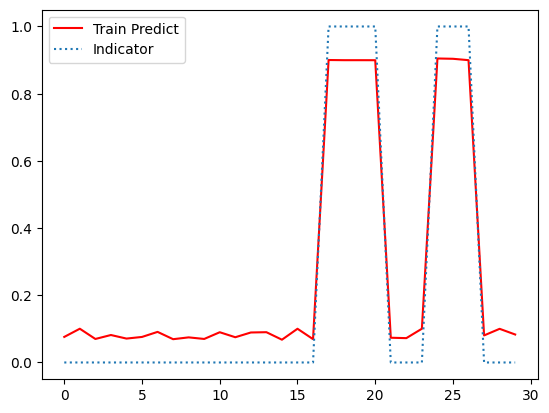

In [40]:
plt.figure(dpi=100)

plt.plot(np.arange(0, len(y_pred_train), 1), y_pred_train, 
         label="Train Predict", color="red")
plt.plot(indicator, label="Indicator", linestyle=":")
plt.legend()
plt.show()

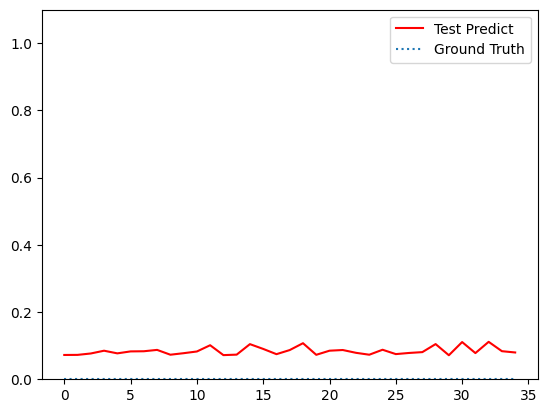

In [41]:
plt.figure(dpi=100)
plt.ylim([0, 1.1])
plt.plot(np.arange(0, len(y_pred_test), 1), y_pred_test, 
         label="Test Predict", color="red")
plt.plot(y_true_2, label="Ground Truth", linestyle=":")
plt.legend()
plt.show()